
# Climatology in Ny Ålesund using cluster analysis of atmospheric soundings

Jussi Tiira <jussi.tiira@helsinki.fi>, University of Helsinki, Department of Physics, Helsinki

NeGI 2017 School – Atmospheric science at high latitudes: Online data storage and visualization tools, Hyytiälä, Finland

Project report

## Abstract <a class="tocSkip">
The daily radiosounding data recorded in Ny Ålesund since 1994 hold information on the climatology of the atmospheric column above the measurement site. Multivariate cluster analysis using K-means was performed on 20 years of the sounding data to analyze patterns in the wind, temperature and relative humidity profiles. Six profile classes were identified and their characteristics described. The classification can be used as a proxy for airmass and weather type and their frequency analysis.

## Introduction

A wide range of atmospheric variables are measured around Ny Ålesund research town in Svalbard including various aerosol measurements. The occurrence of most types of aerosol events such as arctic haze depend strongly on the meteorological conditions, and therefore it is interesting to compare how these events and conditions co-occurr. Often the occurrence of aerosol events is compared separately against single meteorological variables such as wind direction or relative humidity. However, the meteorological variables and their vertical profiles are interconnected and can be used together to describe the atmospheric state. The aim of this project is to combine the vertical profiles of wind speed and direction, temperature and relative humidity as measured with Ny Ålesund atmospheric soundins to create a classification for the profiles, specific for the location.

Radiosondes have been important measurement instruments for atmospheric scientists since the 19th century and are still widely used today. They are the most inexpensive way for in situ measurements of the basic meteorological variables of an atmospheric column. Conditions in the boundary layer are usually less characteristic for the synoptic situation than those in free atmosphere. Therefore, sounding data are a more stable and meaningful basis for the classification when we want it to represent the atmospheric state.

The workflow for creating the classification and analyzing the results is shown in code cells along this report. To increase the readability of this report, most of the analysis code is written in separate python modules and is called in this notebook, where needed. We start by setting up the environment with required modules and settings.

In [1]:
# Matplotlib magic. Change to "notebook" for interactive plots.
%matplotlib inline
# Set rest of the plotting environment
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats, display
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi'] = 200 # plot resolution
plt.rcParams['figure.figsize'] = 10, 6 # default figure size

import importlib as imp
import datetime
import numpy as np
# constant seed to random number generator to make results reproducible
np.random.seed(42)
import pandas as pd
pd.set_option('display.max_columns', 15)
from os import path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# The below modules are written by me.
# The modules sonde and clustering are written specifically for this project.
import sonde
import clustering as cl
# j24 is my general purpose python module
from j24 import home, learn
from j24.notebook import Caption, show
# Reload changes in the modules.
imp.reload(cl)
imp.reload(sonde)

<module 'sonde' from '/home/jussitii/koodit/negi/sonde.py'>

## Methods

### Data

In this project we use daily Ny Ålesund atmospheric sounding data from years 1996 to 2016 <cite>(Maturilli and Kayser 2016; 2017)</cite><span style="display:none;"><cite data-cite="1877461/GSQJ78FJ"></cite><cite data-cite="1877461/36YJ2LS4"></cite></span> to make the classification. The daily soundings are measured around 11 UTC. In this study we use the wind, temperature and relative humidity profiles from the soundings. The data was retrieved from [Pangaea](https://pangaea.de/) and is licensed under [Creative Commons Attribution 3.0](https://creativecommons.org/licenses/by/3.0/).

#### Preprocessing

Pandas <cite data-cite="1877461/PZBR4C34"></cite> Python module was used for reading the sounding data. Prior to the clustering process, some filtering and other preprocessing was performed.

For some days there are additional soundings, that need to be excluded for consistency of the time of the day. In this study only soundings performed between 10 and 12 UTC are used, which includes all the regular daily soundings. The analysis should be limited to only tropospheric data, and therefore profiles are cut at 10 km.

In the sounding data, wind vectors are expressed as wind speed and direction. In the point of view of the clustering, the problem with this format is that wind direction is not a continuous value. Therefore, the wind vector is transformed into southerly and westerly components, $u$ and $v$ respectively.

In [2]:
# Read previously processed data from HDF5 file.
datadir = path.join(home(), 'DATA', 'pangaea', 'sonde')
#datadir = '.'
storage_path = path.join(datadir, '96-16prep.h5')
data = pd.read_hdf(storage_path, 'data')
#times = sonde.launch_times(data)

data.tail() # show the last rows of the preprocessed data
# Columns date, u and v were added in the preprocessing phase.

,time,id,h,lat,lon,p,t,rh,ws,wd,date,u,v
149494,2016-12-31 11:35:20,L4643498,9800,78.79,11.71,240.2,-60.7,8.0,9.8,354.0,2016-12-31,1.024379e+00,-9.746315
149495,2016-12-31 11:35:32,L4643498,9850,78.79,11.72,238.3,-60.6,7.0,10.1,356.0,2016-12-31,7.045404e-01,-10.075397
149496,2016-12-31 11:35:44,L4643498,9900,78.79,11.72,236.4,-60.6,6.0,10.3,358.0,2016-12-31,3.594648e-01,-10.293726
149497,2016-12-31 11:35:57,L4643498,9950,78.79,11.72,234.5,-60.5,6.0,10.4,359.0,2016-12-31,1.815050e-01,-10.398416
149498,2016-12-31 11:36:09,L4643498,10000,78.79,11.72,232.7,-60.2,6.0,10.6,360.0,2016-12-31,3.245314e-15,-10.600000


In [3]:
# select wind, temperature and relative humidity profiles for clustering
ww = cl.wind4clus(data) # wind u and v components 
tt = cl.t4clus(data, col='t') # temperature
hh = cl.t4clus(data, col='rh') # relative humidity
clus_vars = (ww, tt, hh)

tt.tail() # example of temperature data

date,1996-01-01 00:00:00,1996-01-02 00:00:00,1996-01-03 00:00:00,1996-01-04 00:00:00,1996-01-05 00:00:00,1996-01-06 00:00:00,1996-01-08 00:00:00,...,2016-12-20 00:00:00,2016-12-22 00:00:00,2016-12-24 00:00:00,2016-12-25 00:00:00,2016-12-27 00:00:00,2016-12-29 00:00:00,2016-12-31 00:00:00
h,,,,,,,,,,,,,,,
250,-23.8,-24.4,-26.2,-24.4,-16.3,-13.6,-5.3,...,-6.0,-0.3,-7.0,-5.7,-3.6,-3.5,-9.9
200,-23.4,-24.0,-25.9,-24.2,-16.8,-13.4,-4.8,...,-5.5,0.2,-6.5,-5.2,-3.2,-3.0,-9.7
150,-23.2,-23.6,-25.6,-23.9,-16.9,-13.3,-4.3,...,-5.0,0.5,-6.1,-4.8,-2.9,-2.6,-9.4
100,-23.0,-23.2,-25.3,-23.4,-16.8,-13.3,-3.9,...,-4.6,0.9,-5.6,-4.3,-2.8,-2.0,-9.0
50,-23.5,-23.3,-25.4,-23.2,-16.9,-13.4,-3.6,...,-4.6,1.1,-5.4,-4.4,-3.6,-1.6,-9.6


### Selecting the number of classes

An important but non-trivial consideration in using K-means clustering is the choice of number of clusters. Several methods exist for calculating 

Use Silhouette Coefficient for calculating scores for K-means using different numbers of clusters.

The optimal number of clusters depends on variability of meteorological conditions and correlations between different variables.

* Method to calculate how well measurements represent given clusters on average.

In [4]:
wtr, isplit = cl.concat(clus_vars) # wtr: "wind, temperature, humidity"
n_clus = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
scores = cl.scores(wtr, n_clus=n_clus, score_func=silhouette_score)

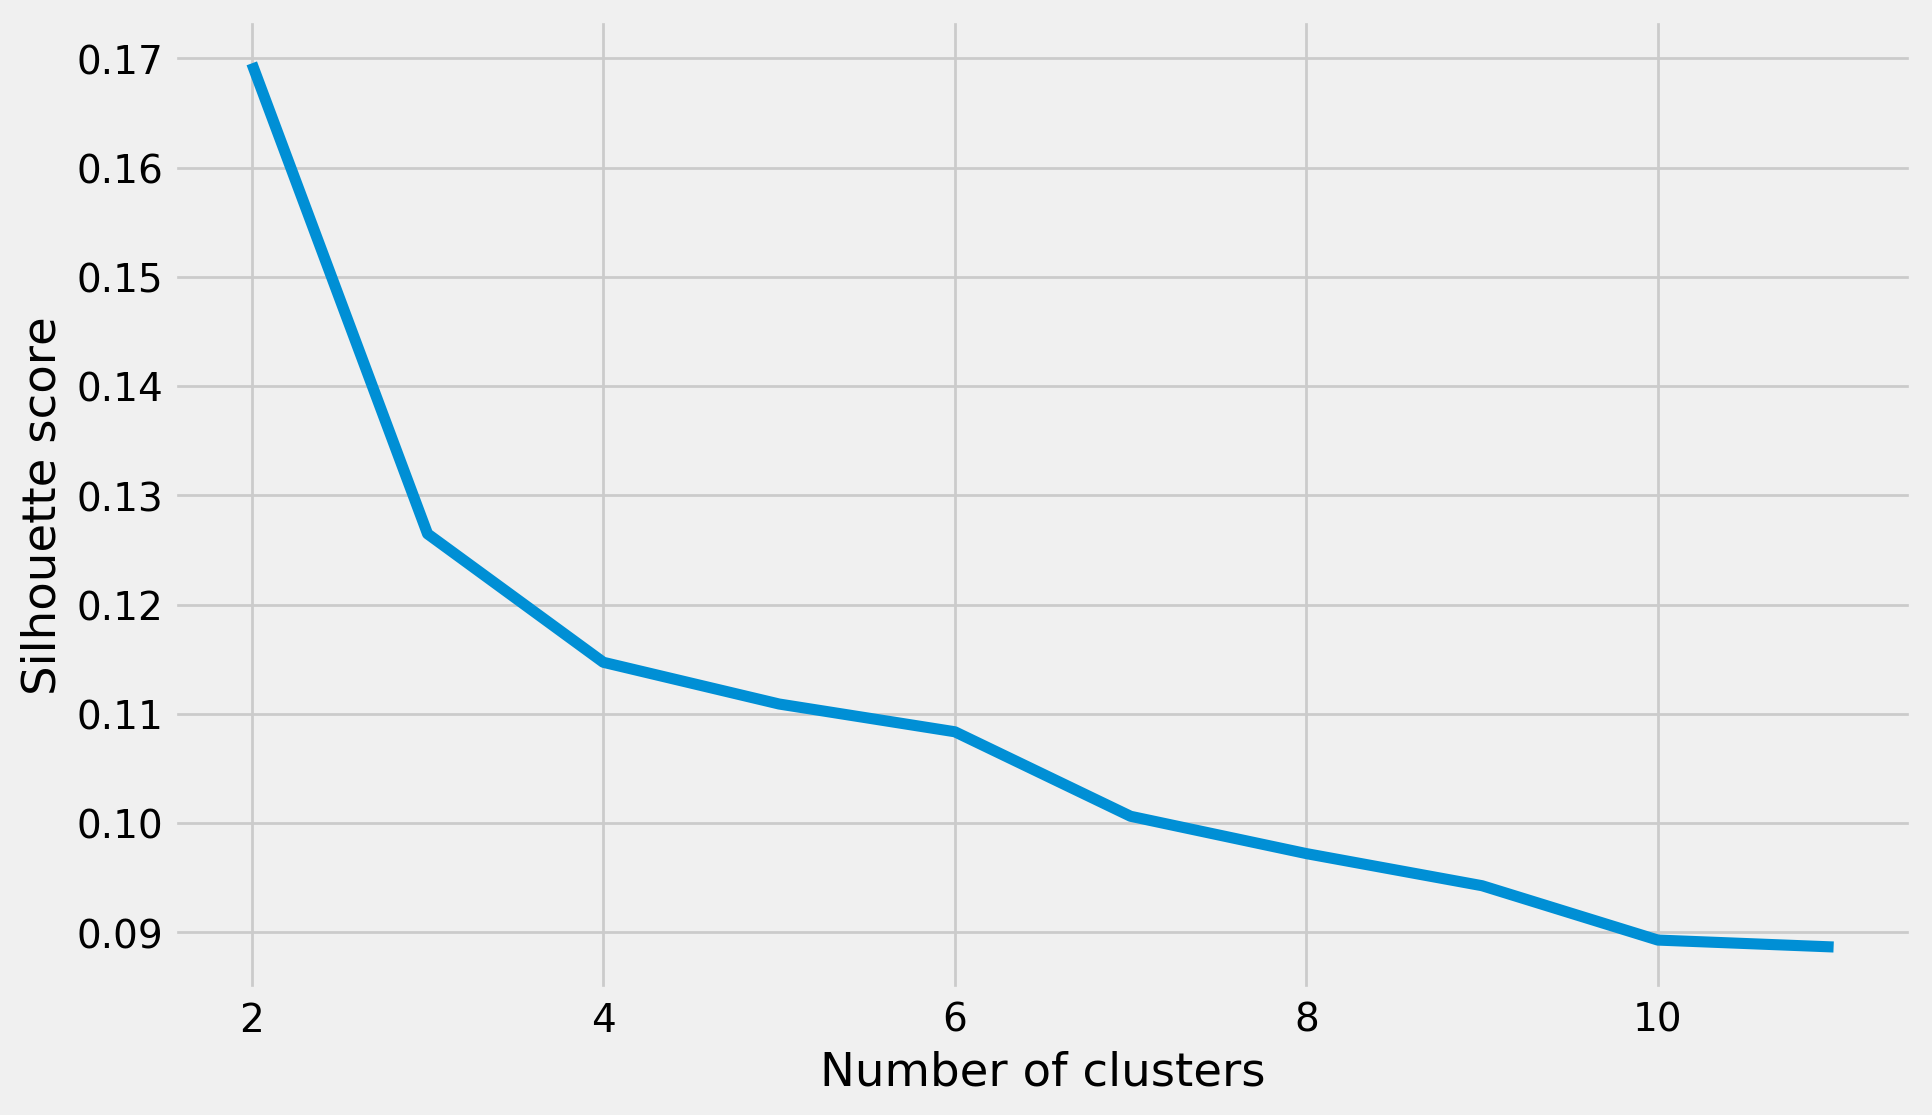

In [5]:
n_clus = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(num=1)
    cl.plot_scores(n_clus, scores, ax=ax)
show(fig, caption='Silhouette score as a function of number of clusters.')

In [6]:
km = KMeans(init='k-means++', n_clusters=6, n_init=40, n_jobs=-1)

classes = learn.fit_predict(wtr, km)
cen = learn.centroids(wtr, km)
cw, ct, ch = cl.split(cen, isplit) # centroids of wind, temperature and humidity

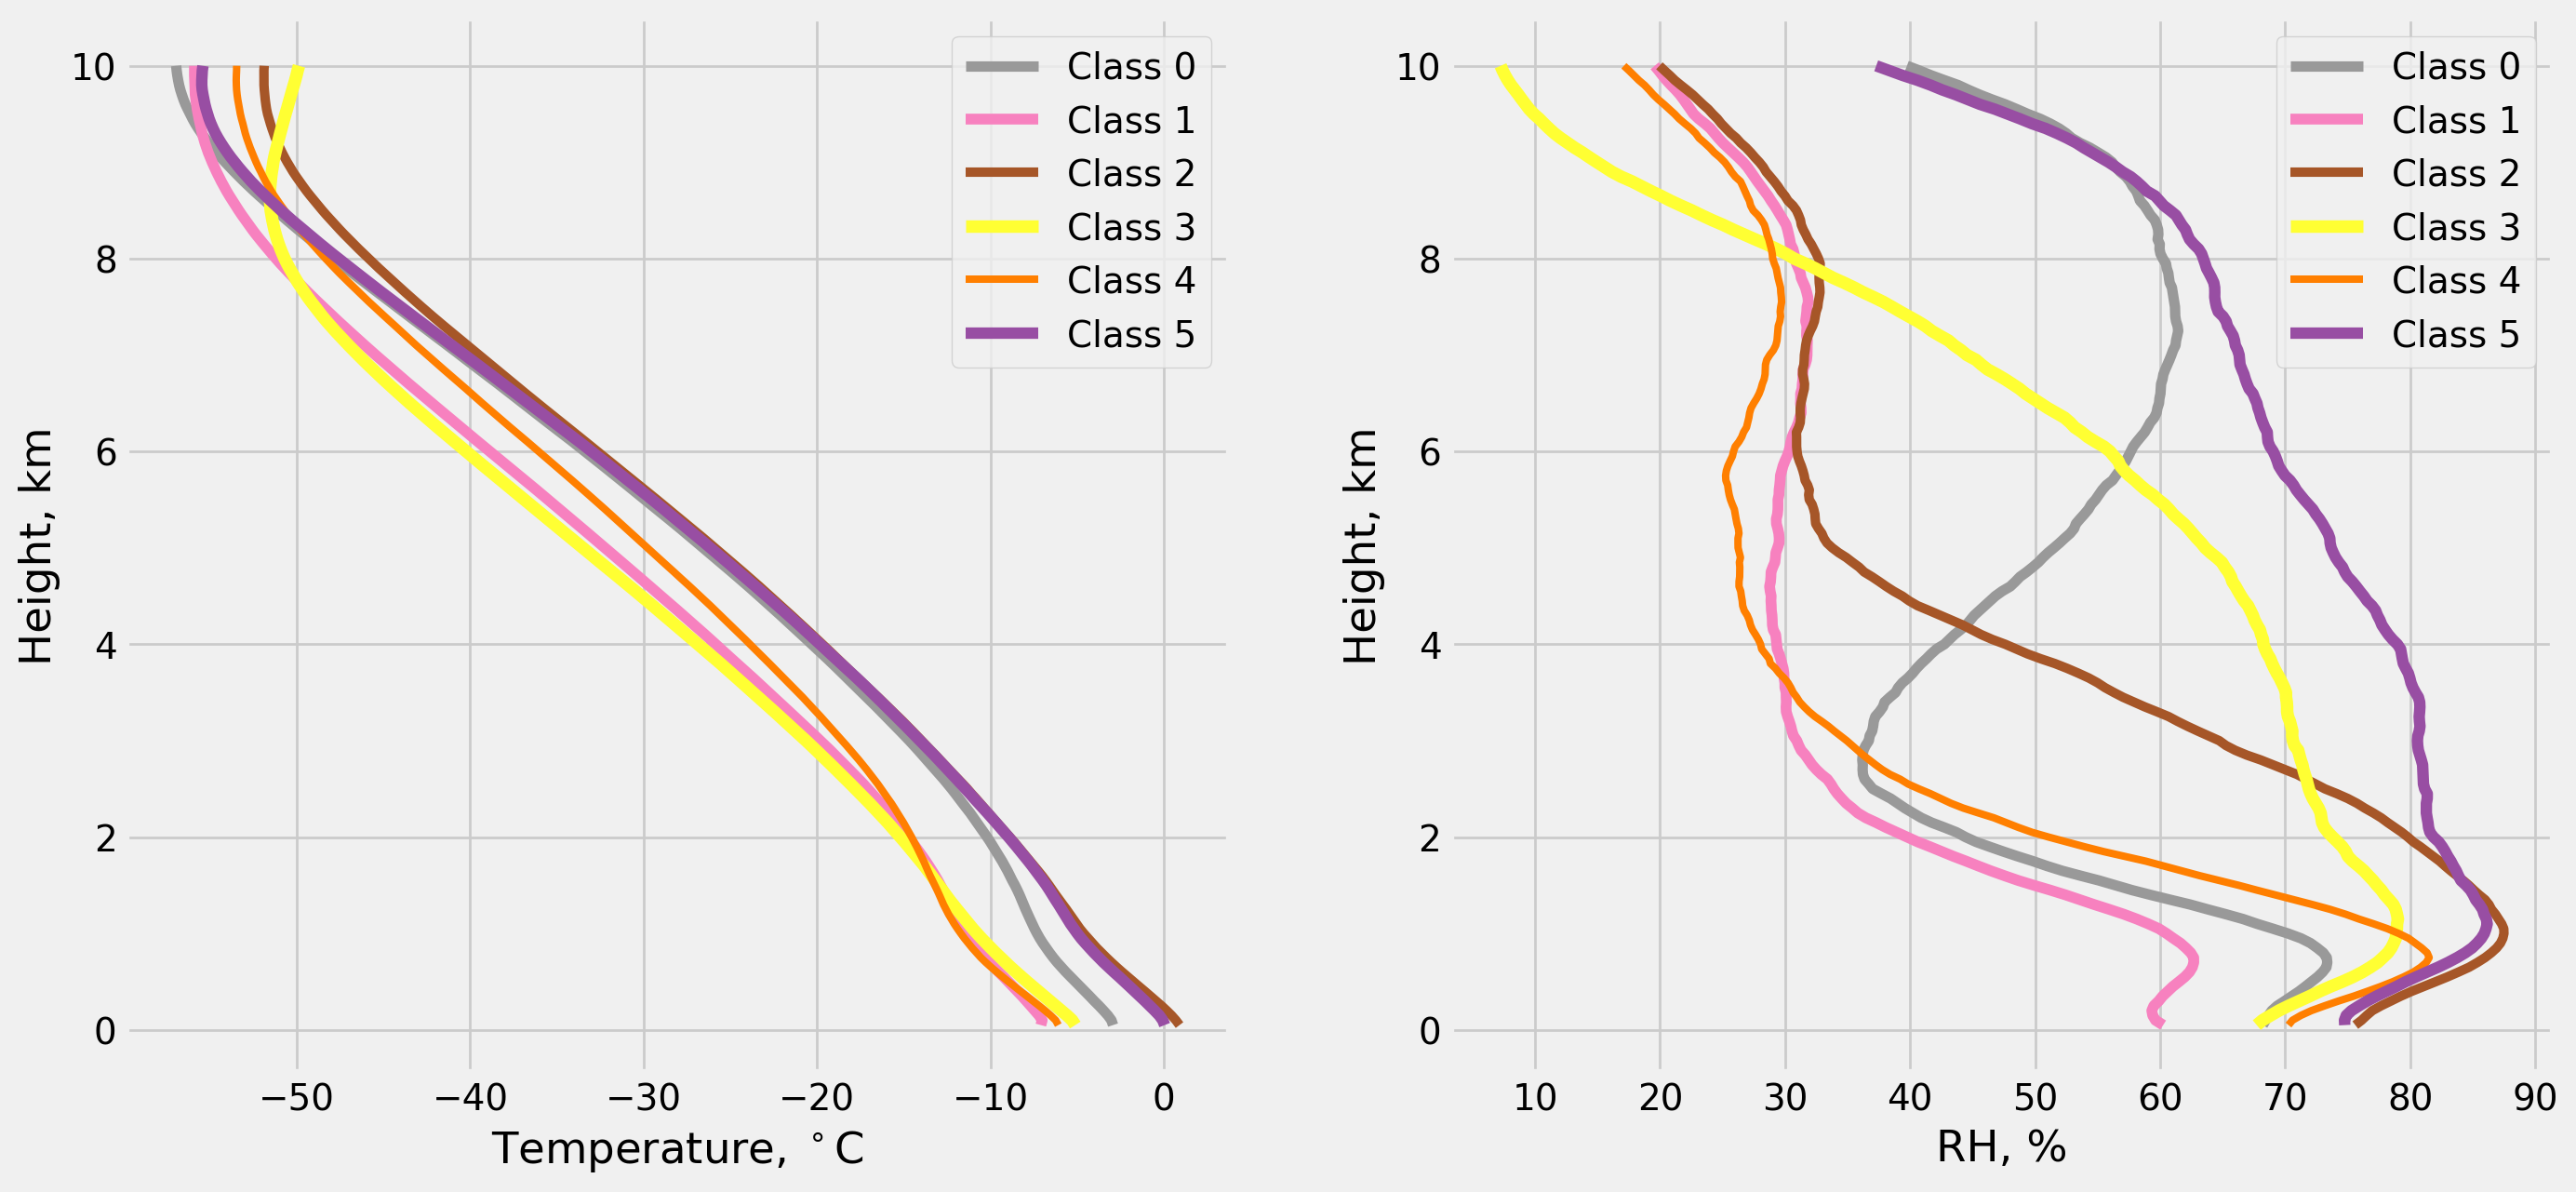

In [13]:
class_sizes = learn.normalized_class_sizes(classes)
linewidths = class_sizes*4
with plt.style.context('fivethirtyeight'):
    fig_profs, axarr = plt.subplots(1, 2, figsize=(15, 7), num=2)
    cl.plot_profiles(ct, ax=axarr[0], linewidths=linewidths)
    axarr[0].set_xlabel('Temperature, $^\circ$C')
    cl.plot_profiles(ch, ax=axarr[1], linewidths=linewidths)
    axarr[1].set_xlabel('RH, %')
show(fig_profs, caption='Temperature and relative humidity profiles of the K-means cluster centroids.')

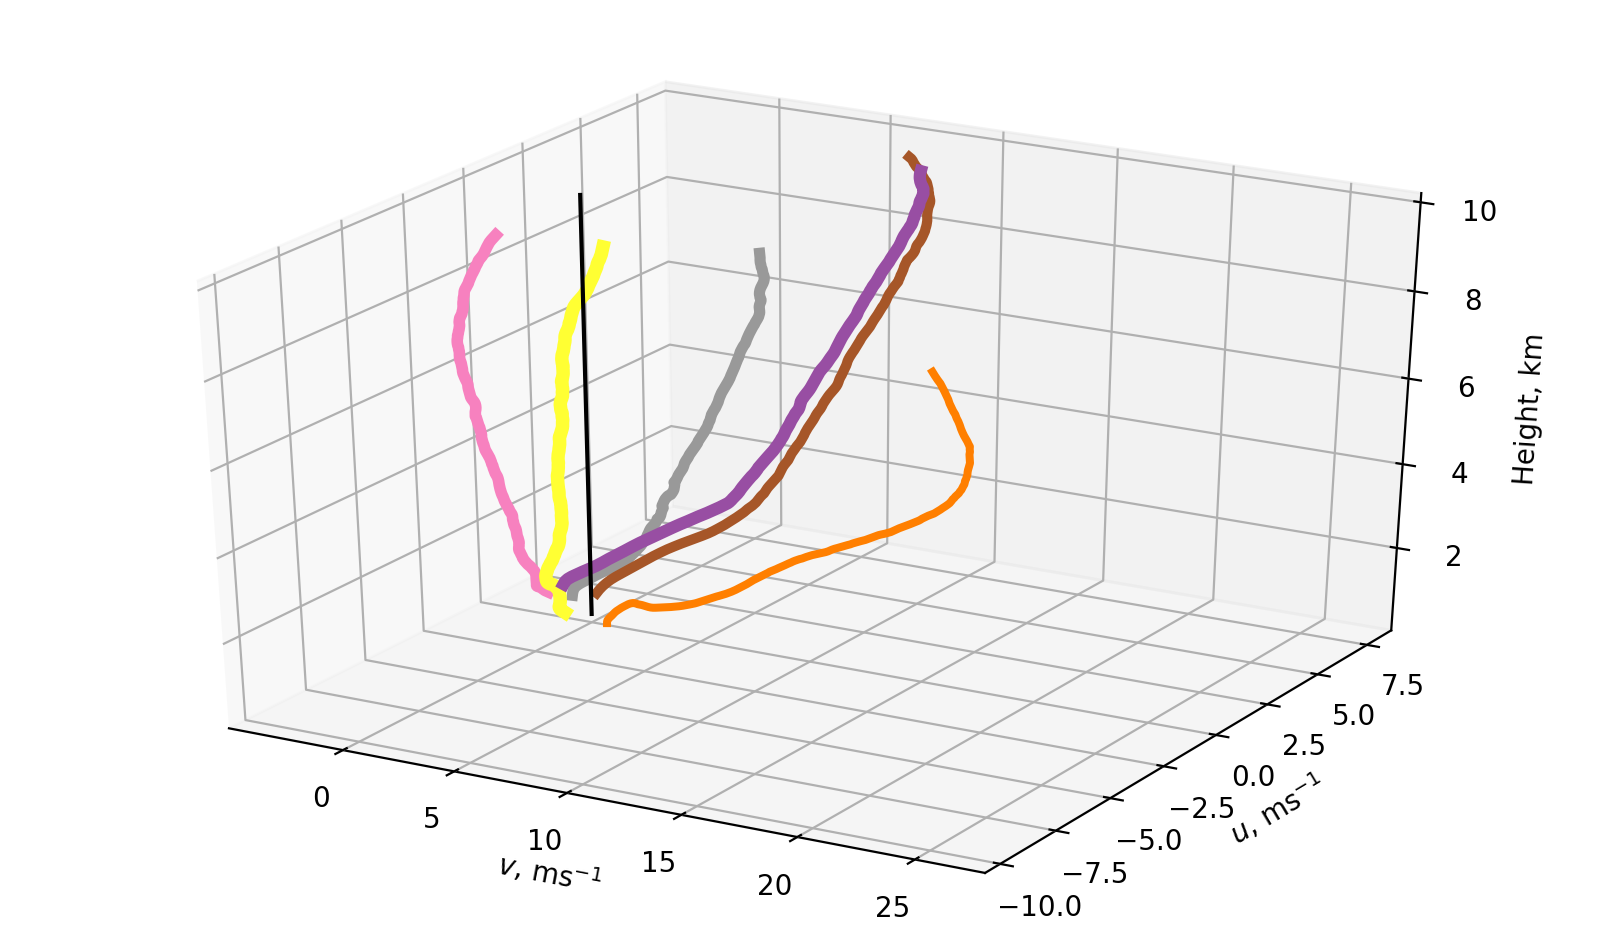

In [18]:
ax_wind = cl.plot_w_centroids(cw, linewidths=linewidths)
fig_wind = ax_wind.get_figure()
fig_wind.number = 3
class_sizes # relative sizes
show(fig_wind, caption='Wind profiles of the class centroids.')

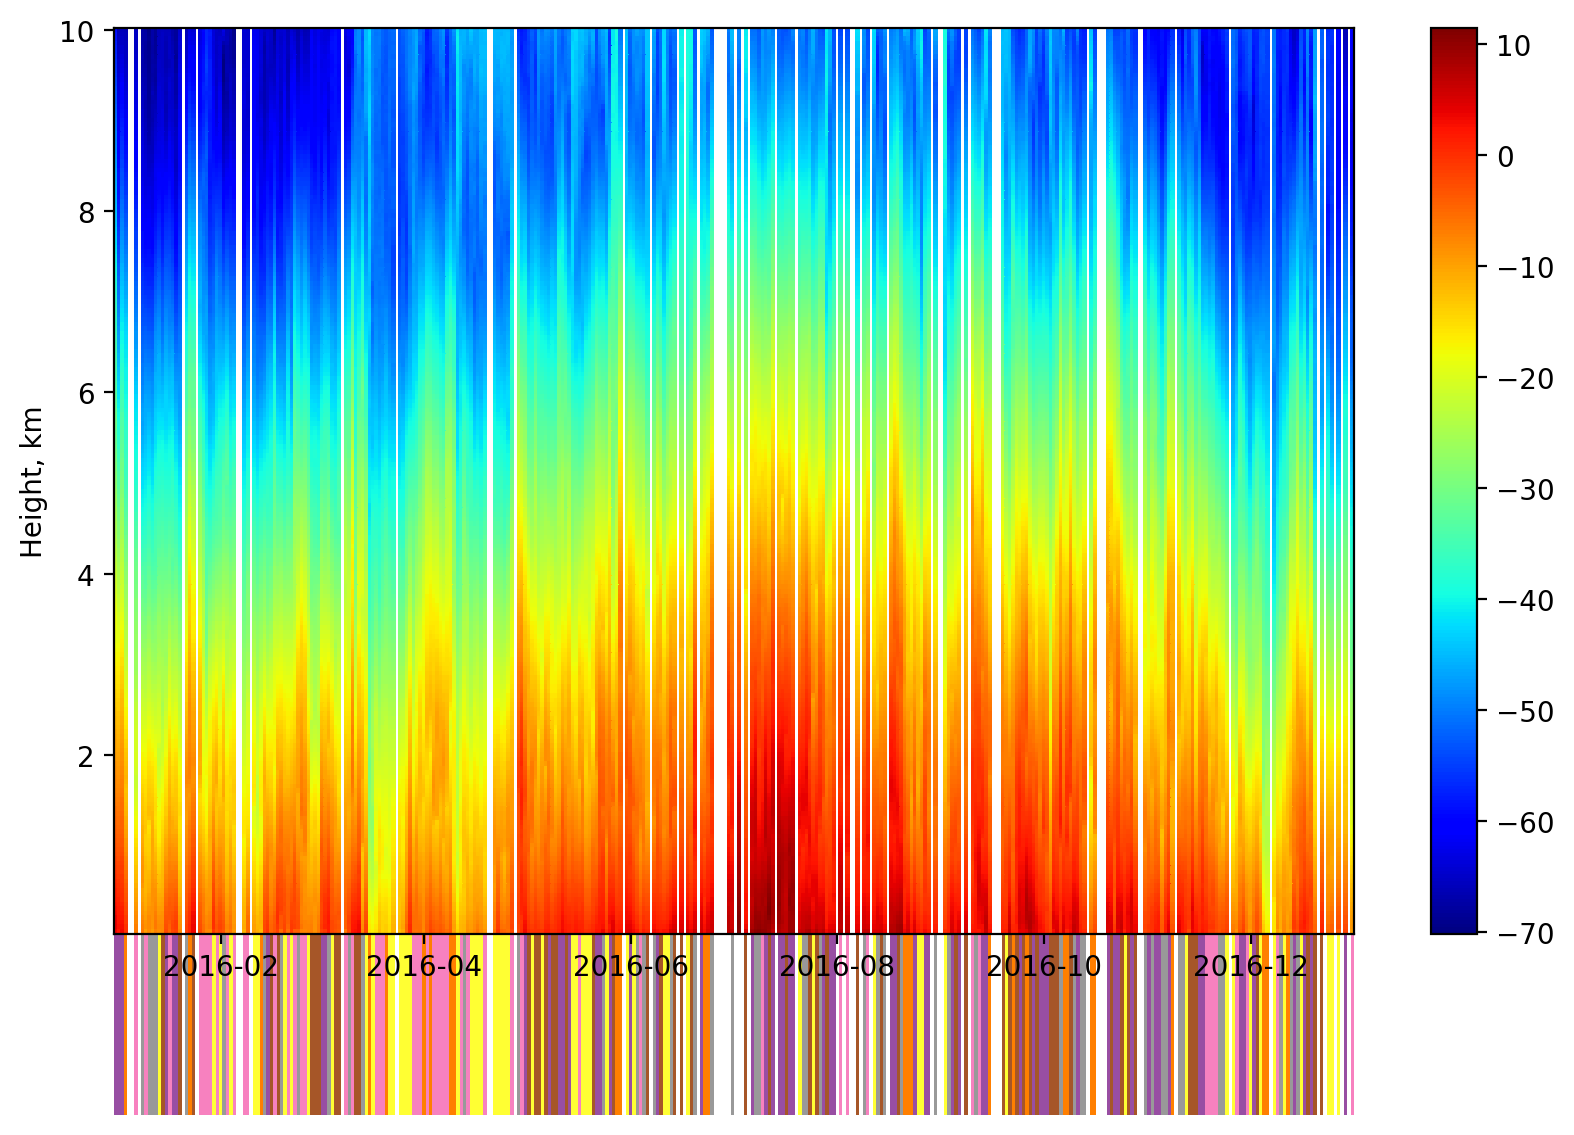

In [9]:
year = 2016
start = datetime.datetime(year-1, 12, 31)
end = datetime.datetime(year+1, 1, 1)
t = sonde.resample_transpose(tt)
selection = (t.columns<end) & (t.columns>start)
t = t.loc[:,selection]
cla = classes.resample('1D').asfreq()
sel = (cla.index<end) & (cla.index>start)
cla = cla.loc[sel]

fig_year, ax_year = plt.subplots(num=4)
sonde.heatmap(t, classes=cla, ax=ax_year)
#sonde.heatmap(h, classes=cla)
#ax.set_title('Temperature profiles of the year {}'.format(year))
caption = 'Temperature profiles for the year {}. '
caption += 'The classification of individual profiles is denoted with color coding in the bottom.'
show(fig_year, caption=caption.format(year))

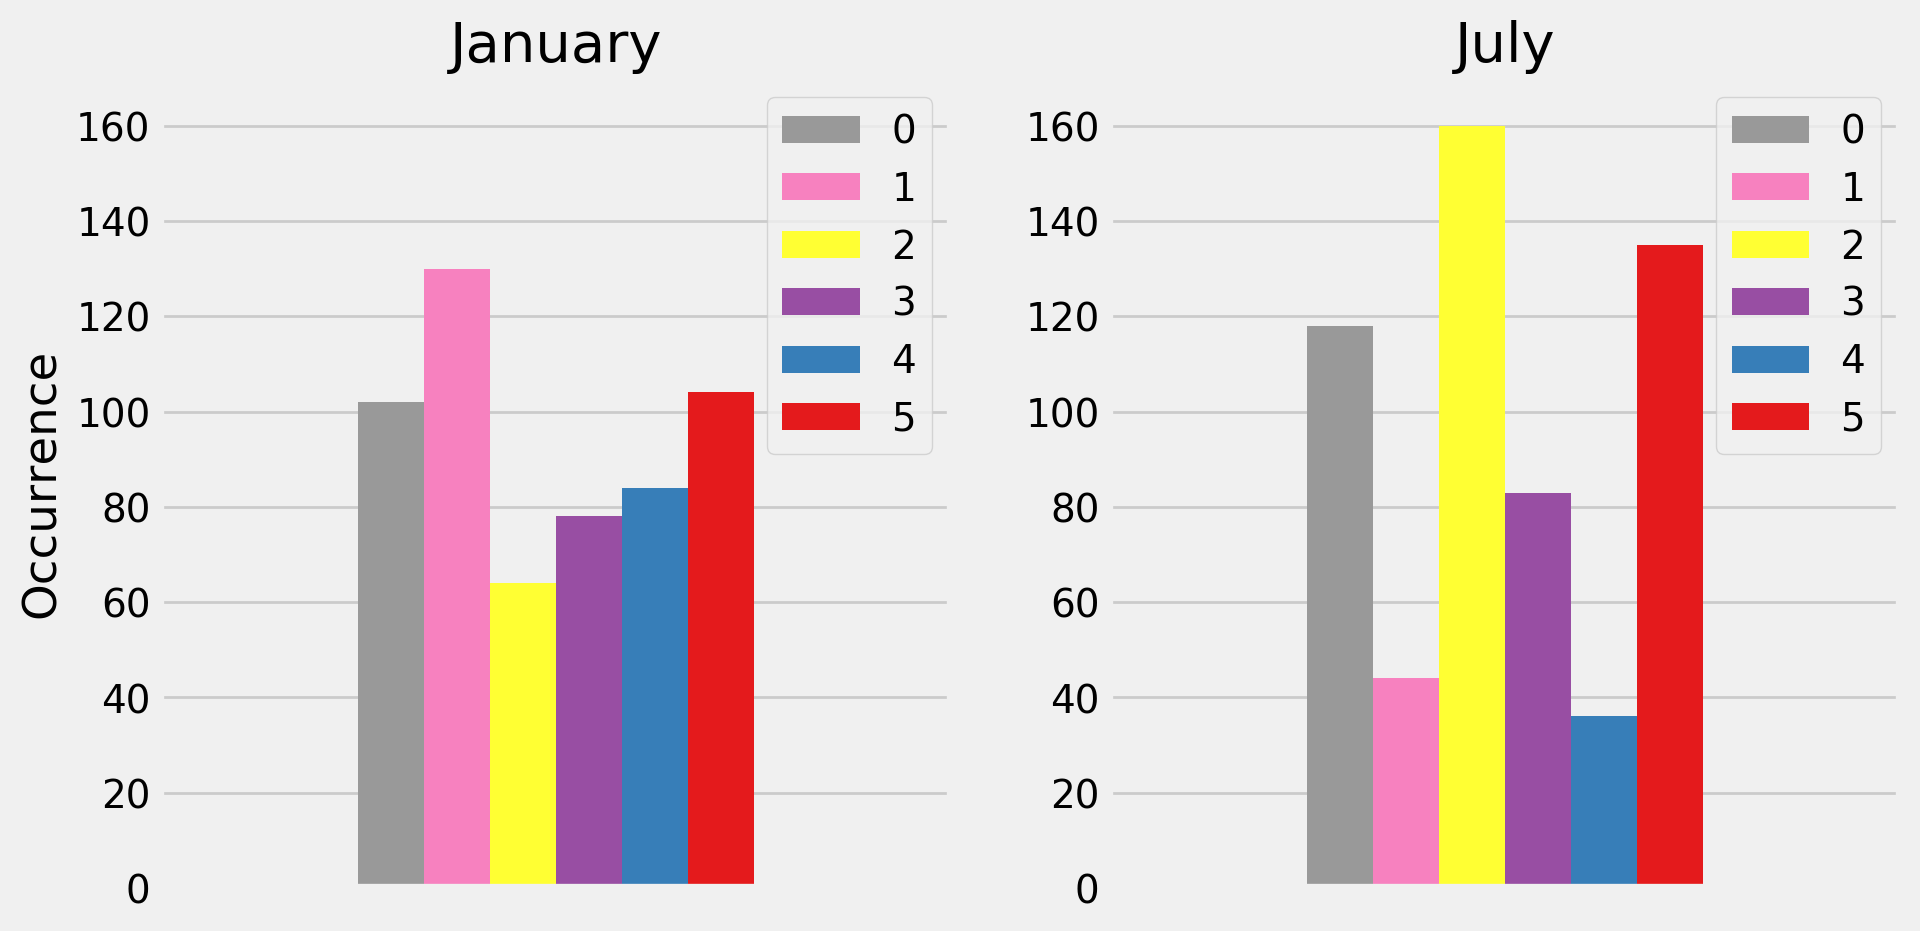

In [12]:
with plt.style.context('fivethirtyeight'):
    fig_occ, ax_occ = plt.subplots(1, 2, figsize=(10,5), num=5)
    month = pd.Series(data=classes.index.month, index=classes.index)
    g = classes.groupby(month)
    jan = g.get_group(1)
    jul = g.get_group(7)
    pd.DataFrame(jan.groupby(jan).count()).T.plot.bar(cmap=sonde.DEFAULT_DISCRETE_CMAP, ax=ax_occ[0])
    ax_occ[0].set_title('January')
    pd.DataFrame(jul.groupby(jul).count()).T.plot.bar(cmap=sonde.DEFAULT_DISCRETE_CMAP, ax=ax_occ[1])
    ax_occ[1].set_title('July')
    for ax in ax_occ:
        ax.xaxis.set_visible(False)
        ax.set_ylim(top=170)
    ax_occ[0].set_ylabel('Occurrence')
show(fig_occ, caption='Class occurrence in winter and summer.')

## Conclusions

* The method is able to produce 6 distinct, meterologically meaningful clusters
* Two clusters (purple and red) represent North-Easternly winds, while yellow and pink represent Southernly winds
* Two classes have strong seasonal variation

## References

<div class="cite2c-biblio"></div>